In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, print_results,sphere_mask,fourier_filter,get_gradient_P

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/July_15_2016_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

rot_axes = ['xz', 'y', 'yz', 'xy', 'x', 'z']
ax_to_idx = {}
for rot_ax in rot_axes:
    ax_to_idx[rot_ax] = rot_axes.index(rot_ax)
print ax_to_idx

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']
{'xy': 3, 'xz': 0, 'yz': 2, 'y': 1, 'x': 4, 'z': 5}


In [6]:
def normalize(volume, scale):
    assert((volume >= 0).all())
    return volume * scale

In [7]:
def Max_displacement(dRM, R_axis, dt):
    rad = 100
    trans_R = rad*np.sqrt(3-np.trace(dRM))
    E_max = np.sqrt(trans_R**2 + 2*trans_R*np.linalg.norm(dt-(dt.T.dot(R_axis))*R_axis) + (dt.T).dot(dt))
    return trans_R, E_max

In [8]:
def RMS_Rotation(dRM):
    return np.arccos((np.trace(dRM)-1)/2.)*180/np.pi

def RMS_Translation(dt):
    t = dt
    return np.sqrt((t.T).dot(t))
def RMS_Translation_R(dRM):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A)))

def RMS(dRM, dt, res_f):
    rad = 100
    A = dRM - np.eye(3)
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A))+ (dt.T).dot(dt))
    
from conversion import rotation_matrix_fromq, rotation_matrix_from_params
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    true_RM = rotation_matrix_fromq(rot_angle[0],wx,wy,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], true_RM

def get_params(errors, Ps, res):
    params = Ps[-1]
    RM = rotation_matrix_from_params(-params[3:])
    return  params[:3]*res, RM

In [9]:
keys = ['xz', 'y', 'yz', 'xy', 'x', 'z']
def compute_RMS(cost_dict_6_4, cost_dict_8, cost_dict_10, grad_idx = 2):
    true_params = []
    Max_dis_6_4 = []
    Max_dis_R_6_4 = []
    RMS_ls_6_4 = []
    RMS_rotation_ls_6_4 = []
    RMS_translation_ls_6_4 = []
    RMS_trans_R_6_4 = []
    counter_6_4 = []
    
    Max_dis_8 = []
    Max_dis_R_8 = []
    RMS_ls_8 = []
    RMS_rotation_ls_8 = []
    RMS_translation_ls_8 = []
    RMS_trans_R_8 = []
    counter_8 = []
    
    Max_dis_10 = []
    Max_dis_R_10 = []
    RMS_ls_10 = []
    RMS_rotation_ls_10 = []
    RMS_translation_ls_10 = []
    RMS_trans_R_10 = []
    counter_10 = []
    for ix, rot_ax in enumerate(keys):
        for rang in ranges:
            ref = rep_to_angle(0,rang)
            for rep in xrange(1,36):
                rot_angle = rep_to_angle(rep,rang)
                true_params.append(rot_angle)
                true_t, true_RM = get_true_params(rot_angle,rot_ax)

                res = '6_4'
                res_f =  6.4
                rad = res_to_rad(res)
                errors, Ps, counter = cost_dict_6_4[ix][grad_idx][rot_angle]
                #errors, Ps = cost_dict_6_4[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_6_4.append(E_Max)
                Max_dis_R_6_4.append(max_trans_R)
                RMS_ls_6_4.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > 1):
                    print ix, rot_ax, rang, rep
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_6_4.append(RMS_Rotation(dR))
                RMS_translation_ls_6_4.append(RMS_Translation(dt))
                RMS_trans_R_6_4.append(RMS_Translation_R(dR))
                counter_6_4.append(counter)

                res = '8'
                res_f =  8.0
                rad = res_to_rad(res)
                errors, Ps, counter = cost_dict_8[ix][grad_idx][rot_angle]
                #errors, Ps = cost_dict_8[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_8.append(E_Max)
                Max_dis_R_8.append(max_trans_R)
                RMS_ls_8.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > 1):
                    print ix, rot_ax, rang, rep
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_8.append(RMS_Rotation(dR))
                RMS_translation_ls_8.append(RMS_Translation(dt))
                RMS_trans_R_8.append(RMS_Translation_R(dR))
                counter_8.append(counter)

                res = '10'
                res_f =  10.0
                rad = res_to_rad(res)           
                errors, Ps, counter = cost_dict_10[ix][grad_idx][rot_angle]
                #errors, Ps = cost_dict_10[ix][grad_idx][rot_angle]
                R_axis = Ps[-1][3:]/np.linalg.norm(Ps[-1][3:])
                t , RM = get_params(errors, Ps, res_f)
                dt = true_t + t
                dR = RM.dot(true_RM.T)
                max_trans_R, E_Max = Max_displacement(dR, R_axis, dt)
                Max_dis_10.append(E_Max)
                Max_dis_R_10.append(max_trans_R)
                RMS_ls_10.append(RMS(dR, dt, res_f))
                if(RMS(dR, dt, res_f) > 1):
                    print ix, rot_ax, rang, rep
                if(RMS(dR, dt, res_f) > E_Max):
                    print rot_ax, rang, rep, rot_angle
                    print RMS(dR, dt, res_f), E_Max
                RMS_rotation_ls_10.append(RMS_Rotation(dR))
                RMS_translation_ls_10.append(RMS_Translation(dt))
                RMS_trans_R_10.append(RMS_Translation_R(dR))
                counter_10.append(counter)
                
    return [true_params,
            RMS_ls_6_4,RMS_ls_8,RMS_ls_10,
            RMS_rotation_ls_6_4,RMS_rotation_ls_8,RMS_rotation_ls_10, 
            RMS_translation_ls_6_4,RMS_translation_ls_8,RMS_translation_ls_10,
            Max_dis_6_4,Max_dis_8,Max_dis_10,
            Max_dis_R_6_4,Max_dis_R_8,Max_dis_R_10,
            RMS_trans_R_6_4, RMS_trans_R_8, RMS_trans_R_10,
            counter_6_4, counter_8, counter_10]

In [10]:
def plot_RMS(RMS_ls, interpolation):
    x = np.arange(0,70,1)
    labels = RMS_ls[0][:70]
    resolutions = ['6.4','8','10']
    for idx in xrange(3): # RMS
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+1][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    for idx in xrange(3): # RMS for Rotations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+4][i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
        plt.title('%s Rotation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
    for idx in xrange(3): # RMS for Translations only
        plt.figure(figsize=[15,4])
        for i in xrange(6):
            plt.plot(RMS_ls[idx+7][i*70:(i+1)*70], '^' ,label = 'translation axis: '+ axes_dict[axes_dict.keys()[i]])
        plt.title('%s Translation RMS %smm Resolution' % (interpolation, resolutions[idx]))
        plt.xticks(x, labels, rotation='vertical')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [11]:
from scipy.stats import rankdata
def signed_rank_test(array1,array2):
    # Compute difference
    diff = np.array(array1)-np.array(array2)
    # record signs
    sign = np.sign(diff)
    # take absolute value
    abs_diff = abs(diff)

    # find indexes that sort an array
    indexes = np.argsort(abs_diff)

    # sorted difference and signs
    sorted_diff_all = abs_diff[indexes]
    sorted_sign_all = sign[indexes]

    # delete zero differences
    mask = sorted_diff_all >= 1e-10
    sorted_diff = sorted_diff_all[mask]
    sorted_sign = sorted_sign_all[mask]

    # Find max W
    N = len(sorted_diff)
    max_W = N*(N+1)/2.
    sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
    #print N, max_W

    # final difference
    final_diff = sorted_diff*sorted_sign

    # find rank
    rank = rankdata(sorted_diff)

    # final rank
    final_rank = sorted_sign*rank

    # score
    w = np.sum(final_rank)
    
    # z score
    z = (w-0.5)/sigma_w
    return N, max_W, w, z

## Run Gauss Newton with BSplines on all data

In [12]:
cost_dict_bsplines_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_BSpline_GN2_6_4.p','rb'))
cost_dict_bsplines_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_BSpline_GN2_8.p','rb'))
cost_dict_bsplines_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_BSpline_GN2_10.p','rb'))

# RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10,1)
# RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10,2)

#plot_RMS(RMS_bspline, 'bspline')

## Run Gauss Newton with Trilinear on all data

In [13]:
cost_dict_linear_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_Linear_GN2_6_4.p','rb'))
cost_dict_linear_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_Linear_GN2_8.p','rb'))
cost_dict_linear_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_Linear_GN2_10.p','rb'))


# RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)
# RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)

#plot_RMS(RMS_linear, 'linear')

## Run Gauss Newton with Tricubic on all data

In [14]:
cost_dict_cubic_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_tricubic_GN2_6_4.p','rb'))
cost_dict_cubic_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_tricubic_GN2_8.p','rb'))
cost_dict_cubic_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july15_tricubic_GN2_10.p','rb'))

# RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)
# RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)

#plot_RMS(RMS_cubic, 'cubic')

In [15]:
RMS_bspline = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10, 2)
RMS_cubic = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)
RMS_linear = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)

0 xz 3_0_to_5_0 29
0 xz 3_0_to_5_0 23
0 xz 3_0_to_5_0 29
0 xz 3_0_to_5_0 35
5 z 3_0_to_5_0 29
5 z 3_0_to_5_0 34
5 z 3_0_to_5_0 35


In [16]:
RMS_bspline_june8 = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10, 1)
RMS_cubic_june8 = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 1)
RMS_linear_june8 = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 1)

0 xz 3_0_to_5_0 5
0 xz 3_0_to_5_0 11
0 xz 3_0_to_5_0 16
0 xz 3_0_to_5_0 17
0 xz 3_0_to_5_0 17
0 xz 3_0_to_5_0 21
0 xz 3_0_to_5_0 22
0 xz 3_0_to_5_0 22
0 xz 3_0_to_5_0 23
0 xz 3_0_to_5_0 23
0 xz 3_0_to_5_0 23
0 xz 3_0_to_5_0 26
0 xz 3_0_to_5_0 27
0 xz 3_0_to_5_0 27
0 xz 3_0_to_5_0 28
0 xz 3_0_to_5_0 28
0 xz 3_0_to_5_0 28
0 xz 3_0_to_5_0 29
0 xz 3_0_to_5_0 29
0 xz 3_0_to_5_0 29
0 xz 3_0_to_5_0 31
0 xz 3_0_to_5_0 32
0 xz 3_0_to_5_0 32
0 xz 3_0_to_5_0 32
0 xz 3_0_to_5_0 33
0 xz 3_0_to_5_0 33
0 xz 3_0_to_5_0 33
0 xz 3_0_to_5_0 34
0 xz 3_0_to_5_0 34
0 xz 3_0_to_5_0 34
0 xz 3_0_to_5_0 35
0 xz 3_0_to_5_0 35
0 xz 3_0_to_5_0 35
1 y 3_0_to_5_0 35
2 yz 0_5_to_2_5 35
2 yz 3_0_to_5_0 29
2 yz 3_0_to_5_0 31
2 yz 3_0_to_5_0 32
2 yz 3_0_to_5_0 33
2 yz 3_0_to_5_0 34
2 yz 3_0_to_5_0 35
2 yz 3_0_to_5_0 35
3 xy 3_0_to_5_0 27
3 xy 3_0_to_5_0 28
3 xy 3_0_to_5_0 29
3 xy 3_0_to_5_0 31
3 xy 3_0_to_5_0 32
3 xy 3_0_to_5_0 33
3 xy 3_0_to_5_0 34
3 xy 3_0_to_5_0 35
4 x 3_0_to_5_0 17
4 x 3_0_to_5_0 23
4 x 3_0_to_5_0 2

In [19]:
RMS_bspline_june8_2 = compute_RMS(cost_dict_bsplines_6_4,cost_dict_bsplines_8,cost_dict_bsplines_10, 2)
RMS_cubic_june8_2 = compute_RMS(cost_dict_cubic_6_4,cost_dict_cubic_8,cost_dict_cubic_10, 2)
RMS_linear_june8_2 = compute_RMS(cost_dict_linear_6_4,cost_dict_linear_8,cost_dict_linear_10, 2)

0 xz 3_0_to_5_0 29


In [20]:
RMS_linear_oct13 = pickle.load(open('RMS_linear_oct13.p','rb'))
RMS_cubic_oct13 = pickle.load(open('RMS_cubic_oct13.p','rb'))
RMS_bspline_oct13 = pickle.load(open('RMS_bspline_oct13.p','rb'))

In [21]:
RMS_linear_oct13_2 = pickle.load(open('RMS_linear_oct13_2.p','rb'))
RMS_cubic_oct13_2 = pickle.load(open('RMS_cubic_oct13_2.p','rb'))
RMS_bspline_oct13_2 = pickle.load(open('RMS_bspline_oct13_2.p','rb'))

In [82]:
order = open("/Users/zyzdiana/Desktop/order.txt", "w")
for i in RMS_linear_oct13_2[0]:
    order.write(str(i[0]) + ' ' + str(i[1]) + '\n')
order.close()

In [97]:
np.max(RMS_bspline_oct13_2[1])

0.83474612736403297

In [105]:
np.argmax(RMS_bspline_oct13_2[1][:70])

69

In [101]:
len(RMS_bspline_oct13_2[3])

420

In [106]:
len(RMS_linear_oct13_2[0])

420

In [107]:
oct13_RMS_bspline_6_4 = open("/Users/zyzdiana/Desktop/oct13_RMS_bspline_6_4.txt", "w")
june8_RMS_bspline_6_4 = open("/Users/zyzdiana/Desktop/june8_RMS_bspline_6_4.txt", "w")

oct13_RMS_bspline_8 = open("/Users/zyzdiana/Desktop/oct13_RMS_bspline_8.txt", "w")
june8_RMS_bspline_8 = open("/Users/zyzdiana/Desktop/june8_RMS_bspline_8.txt", "w")

oct13_RMS_bspline_10 = open("/Users/zyzdiana/Desktop/oct13_RMS_bspline_10.txt", "w")
june8_RMS_bspline_10 = open("/Users/zyzdiana/Desktop/june8_RMS_bspline_10.txt", "w")

for i in xrange(420):
    oct13_RMS_bspline_6_4.write(str(RMS_bspline_oct13_2[1][i]) + '\n')
    june8_RMS_bspline_6_4.write(str(RMS_bspline_june8_2[1][i]) + '\n')
    
    oct13_RMS_bspline_8.write(str(RMS_bspline_oct13_2[2][i]) + '\n')
    june8_RMS_bspline_8.write(str(RMS_bspline_june8_2[2][i]) + '\n')
    
    oct13_RMS_bspline_10.write(str(RMS_bspline_oct13_2[3][i]) + '\n')
    june8_RMS_bspline_10.write(str(RMS_bspline_june8_2[3][i]) + '\n')
    
oct13_RMS_bspline_6_4.close()
june8_RMS_bspline_6_4.close()
oct13_RMS_bspline_8.close()
june8_RMS_bspline_8.close()
oct13_RMS_bspline_10.close()
june8_RMS_bspline_10.close()

In [108]:
oct13_RMS_cubic_6_4 = open("/Users/zyzdiana/Desktop/oct13_RMS_cubic_6_4.txt", "w")
june8_RMS_cubic_6_4 = open("/Users/zyzdiana/Desktop/june8_RMS_cubic_6_4.txt", "w")

oct13_RMS_cubic_8 = open("/Users/zyzdiana/Desktop/oct13_RMS_cubic_8.txt", "w")
june8_RMS_cubic_8 = open("/Users/zyzdiana/Desktop/june8_RMS_cubic_8.txt", "w")

oct13_RMS_cubic_10 = open("/Users/zyzdiana/Desktop/oct13_RMS_cubic_10.txt", "w")
june8_RMS_cubic_10 = open("/Users/zyzdiana/Desktop/june8_RMS_cubic_10.txt", "w")

for i in xrange(420):
    oct13_RMS_cubic_6_4.write(str(RMS_cubic_oct13_2[1][i]) + '\n')
    june8_RMS_cubic_6_4.write(str(RMS_cubic_june8_2[1][i]) + '\n')
    
    oct13_RMS_cubic_8.write(str(RMS_cubic_oct13_2[2][i]) + '\n')
    june8_RMS_cubic_8.write(str(RMS_cubic_june8_2[2][i]) + '\n')
    
    oct13_RMS_cubic_10.write(str(RMS_cubic_oct13_2[3][i]) + '\n')
    june8_RMS_cubic_10.write(str(RMS_cubic_june8_2[3][i]) + '\n')
    
oct13_RMS_cubic_6_4.close()
june8_RMS_cubic_6_4.close()
oct13_RMS_cubic_8.close()
june8_RMS_cubic_8.close()
oct13_RMS_cubic_10.close()
june8_RMS_cubic_10.close()

In [109]:
oct13_RMS_linear_6_4 = open("/Users/zyzdiana/Desktop/oct13_RMS_linear_6_4.txt", "w")
june8_RMS_linear_6_4 = open("/Users/zyzdiana/Desktop/june8_RMS_linear_6_4.txt", "w")

oct13_RMS_linear_8 = open("/Users/zyzdiana/Desktop/oct13_RMS_linear_8.txt", "w")
june8_RMS_linear_8 = open("/Users/zyzdiana/Desktop/june8_RMS_linear_8.txt", "w")

oct13_RMS_linear_10 = open("/Users/zyzdiana/Desktop/oct13_RMS_linear_10.txt", "w")
june8_RMS_linear_10 = open("/Users/zyzdiana/Desktop/june8_RMS_linear_10.txt", "w")

for i in xrange(420):
    oct13_RMS_linear_6_4.write(str(RMS_linear_oct13_2[1][i]) + '\n')
    june8_RMS_linear_6_4.write(str(RMS_linear_june8_2[1][i]) + '\n')
    
    oct13_RMS_linear_8.write(str(RMS_linear_oct13_2[2][i]) + '\n')
    june8_RMS_linear_8.write(str(RMS_linear_june8_2[2][i]) + '\n')
    
    oct13_RMS_linear_10.write(str(RMS_linear_oct13_2[3][i]) + '\n')
    june8_RMS_linear_10.write(str(RMS_linear_june8_2[3][i]) + '\n')
    
oct13_RMS_linear_6_4.close()
june8_RMS_linear_6_4.close()
oct13_RMS_linear_8.close()
june8_RMS_linear_8.close()
oct13_RMS_linear_10.close()
june8_RMS_linear_10.close()

In [22]:
# Taking average between the two sets
RMS_bspline = []
RMS_cubic = []
RMS_linear = []
RMS_bspline.append(RMS_bspline_june8[0])
RMS_cubic.append(RMS_cubic_june8[0])
RMS_linear.append(RMS_linear_june8[0])
for i in xrange(1,22):
    RMS_bspline.append((np.array(RMS_bspline_june8[i]) + np.array(RMS_bspline_oct13[i]))/2.0)
    RMS_cubic.append((np.array(RMS_cubic_june8[i]) + np.array(RMS_cubic_oct13[i]))/2.0)
    RMS_linear.append((np.array(RMS_linear_june8[i]) + np.array(RMS_linear_oct13[i]))/2.0)

In [23]:
# Combining the two test for wilcoxon
RMS_bspline = []
RMS_cubic = []
RMS_linear = []
RMS_bspline.append(RMS_bspline_june8_2[0])
RMS_cubic.append(RMS_cubic_june8_2[0])
RMS_linear.append(RMS_linear_june8_2[0])
for i in xrange(1,22):
    RMS_bspline.append(RMS_bspline_june8_2[i] + RMS_bspline_oct13_2[i])
    RMS_cubic.append(RMS_cubic_june8_2[i] + RMS_cubic_oct13_2[i])
    RMS_linear.append(RMS_linear_june8_2[i] + RMS_linear_oct13_2[i])

In [24]:
# Combining the two test for wilcoxon
RMS_bspline1 = []
RMS_cubic1 = []
RMS_linear1 = []
RMS_bspline1.append(RMS_bspline_june8[0])
RMS_cubic1.append(RMS_cubic_june8[0])
RMS_linear1.append(RMS_linear_june8[0])
for i in xrange(1,22):
    RMS_bspline1.append(RMS_bspline_june8[i] + RMS_bspline_oct13[i])
    RMS_cubic1.append(RMS_cubic_june8[i] + RMS_cubic_oct13[i])
    RMS_linear1.append(RMS_linear_june8[i] + RMS_linear_oct13[i])

In [25]:
# 10mm convergence
print np.median(RMS_bspline1[21])
print np.median(RMS_cubic1[21])
print np.median(RMS_linear1[21])
# 8mm convergence
print np.median(RMS_bspline1[20])
print np.median(RMS_cubic1[20])
print np.median(RMS_linear1[20])
# 6.4mm convergence
print np.median(RMS_bspline1[19])
print np.median(RMS_cubic1[19])
print np.median(RMS_linear1[19])

6.0
8.0
13.0
9.0
10.0
13.0
10.0
10.0
13.0


In [26]:
# 10mm convergence
print np.median(RMS_bspline[-1])
print np.median(RMS_cubic[-1])
print np.median(RMS_linear[-1])
# 8mm convergence
print np.median(RMS_bspline[-2])
print np.median(RMS_cubic[-2])
print np.median(RMS_linear[-2])
# 6.4mm convergence
print np.median(RMS_bspline[-3])
print np.median(RMS_cubic[-3])
print np.median(RMS_linear[-3])

6.0
10.0
10.0
5.0
12.0
10.0
6.0
11.0
10.0


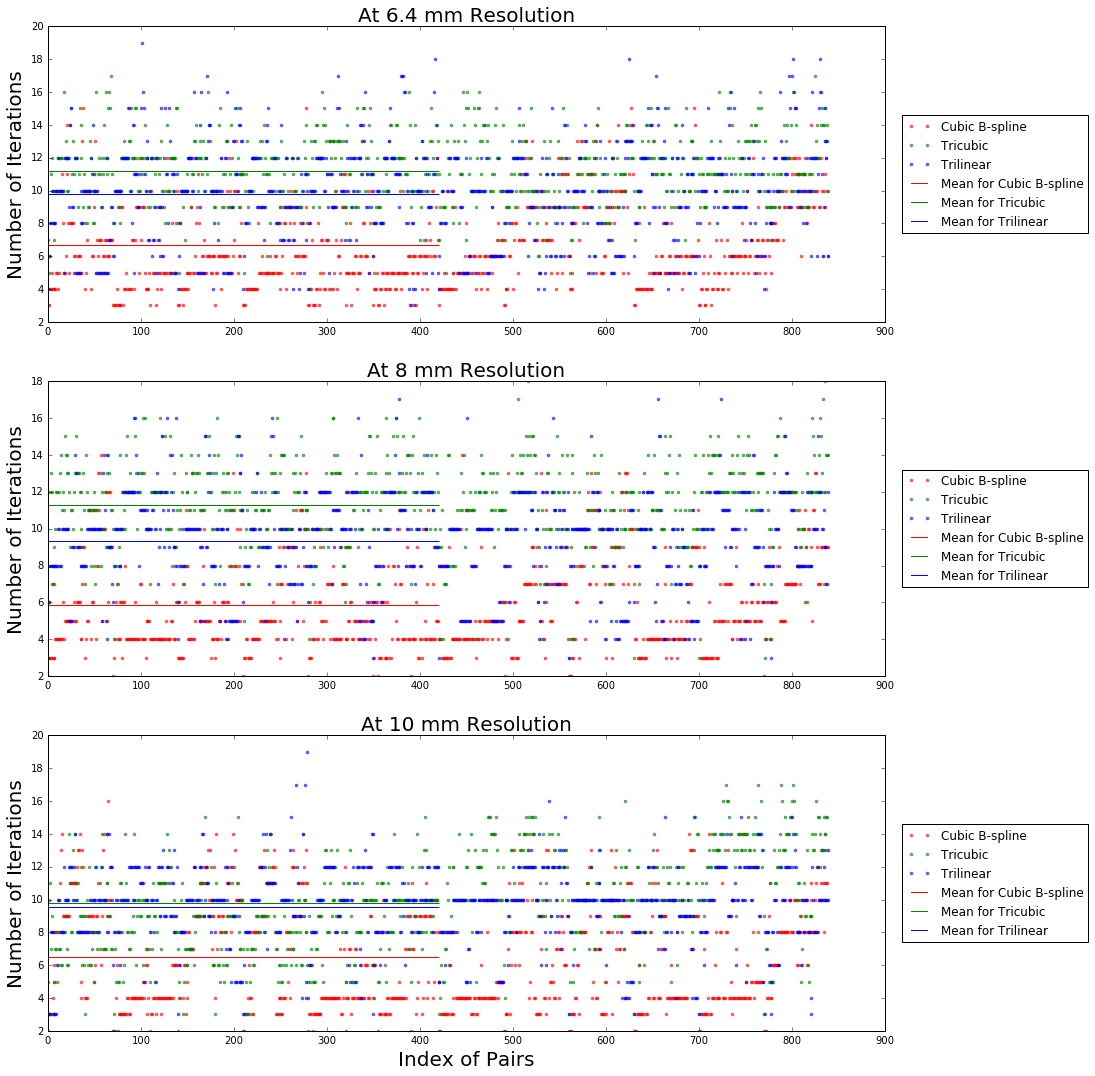

In [27]:
res = ['6.4','8','10']
fontsize = 20
plt.figure(figsize = [15,18])
for i in [-3, -2, -1]:
    plt.subplot(3,1, i+4)
    plt.plot(RMS_bspline[i],'r.', label = 'Cubic B-spline', alpha = 0.6)
    plt.hlines(np.mean(RMS_bspline[i]),0, 420, 'r', label = 'Mean for Cubic B-spline')
    plt.plot(RMS_cubic[i],'g.', label = 'Tricubic', alpha = 0.6)
    plt.hlines(np.mean(RMS_cubic[i]),0, 420, 'g', label = 'Mean for Tricubic')
    plt.plot(RMS_linear[i],'b.', label = 'Trilinear', alpha = 0.6)
    plt.hlines(np.mean(RMS_linear[i]),0, 420, 'b', label = 'Mean for Trilinear')
    plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
    plt.title('At %s mm Resolution' % res[i], fontsize = fontsize)
    if(i == -1):
        plt.xlabel('Index of Pairs', fontsize = fontsize)
    plt.ylabel('Number of Iterations', fontsize = fontsize)
plt.show()

In [28]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+1]),np.max(RMS_cubic[i+1]),np.max(RMS_linear[i+1])]))
xlim_max_rms = np.max(xlims)
print xlim_max_rms

1.00535467308


In [29]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+10]),np.max(RMS_cubic[i+10]),np.max(RMS_linear[i+10])]))
xlim_max = np.max(xlims)
print xlim_max

1.86796845455


In [30]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+4]),np.max(RMS_cubic[i+4]),np.max(RMS_linear[i+4])]))
xlim_max_rot_rms = np.max(xlims)
print xlim_max_rot_rms

0.783675785508


In [31]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+13]),np.max(RMS_cubic[i+13]),np.max(RMS_linear[i+13])]))
xlim_max_rot = np.max(xlims)
print xlim_max_rot

1.36776161076


In [32]:
xlims = []
for i in xrange(3):
    xlims.append(np.max([np.max(RMS_bspline[i+7]),np.max(RMS_cubic[i+7]),np.max(RMS_linear[i+7])]))
xlim_max_trans = np.max(xlims)
print xlim_max_trans

0.852610986194


In [33]:
N = 420
W = N*(N+1)/2.
sigma_w = np.sqrt(N*(N+1)*(2*N+1)/6.)
print (W-0.5)/sigma_w

17.7586876466


In [34]:
pickle.dump(RMS_linear,open('RMS_linear2.p','wb'))
pickle.dump(RMS_cubic,open('RMS_cubic2.p','wb'))
pickle.dump(RMS_bspline,open('RMS_bspline2.p','wb'))

## The Wilcoxon Signed-Rank Test

In [35]:
N = 420*2
np.sqrt(N*(N+1)*(2*N+1)/6.)

14068.437724210888

In [36]:
# Trilinear RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[2],RMS_linear[3])
print 'Trilinear RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[2])
print 'Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_linear[1],RMS_linear[3])
print 'Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Trilinear RMS from 10mm to 8mm (8mm - 10mm) 840 353220.0 -96292.0 -6.84457662518
Trilinear RMS from 8mm to 6.4mm (6.4mm - 8mm) 840 353220.0 -206836.0 -14.7021655179
Trilinear RMS from 10mm to 6.4mm (6.4mm - 10mm) 840 353220.0 -244320.0 -17.3665693938


In [37]:
# Tricubic RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[2],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[2])
print 'Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_cubic[1],RMS_cubic[3])
print 'Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Tricubic RMS from 10mm to 8mm (8mm - 10mm) 840 353220.0 -91014.0 -6.46941059016
Tricubic RMS from 8mm to 6.4mm (6.4mm - 8mm) 840 353220.0 -231472.0 -16.4533194472
Tricubic RMS from 10mm to 6.4mm (6.4mm - 10mm) 840 353220.0 -221194.0 -15.7227479224


In [38]:
# Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[2],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm)', N, max_W, w, z

# Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[2])
print 'Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm)', N, max_W, w, z

# Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)
N, max_W, w, z = signed_rank_test(RMS_bspline[1],RMS_bspline[3])
print 'Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm)', N, max_W, w, z

Cubic B-spline RMS from 10mm to 8mm (8mm - 10mm) 840 353220.0 -57064.0 -4.05620731446
Cubic B-spline RMS from 8mm to 6.4mm (6.4mm - 8mm) 840 353220.0 -216242.0 -15.3707543253
Cubic B-spline RMS from 10mm to 6.4mm (6.4mm - 10mm) 840 353220.0 -169940.0 -12.0795573276


In [39]:
idx = 3
# 10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

10mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 840 353220.0 -110922.0 -7.88449308832
10mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 840 353220.0 -224302.0 -15.9436679749
10mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 840 353220.0 -223398.0 -15.8794106623


In [40]:
idx = 2
# 8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

8mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 840 353220.0 -158754.0 -11.2844441659
8mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 840 353220.0 -256996.0 -18.2675933915
8mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 840 353220.0 -208922.0 -14.8504406883


In [41]:
idx = 1
# 6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_linear[idx])
print '6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear)', N, max_W, w, z

# 6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)
N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_cubic[idx])
print '6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic)', N, max_W, w, z

6.4mm RMS from Trilinear to Tricubic (Tricubic - Trilinear) 840 353220.0 -48208.0 -3.42671311094
6.4mm RMS from Trilinear to Cubic B-spline (Cubic B-spline - Trilinear) 840 353220.0 -176476.0 -12.5441433839
6.4mm RMS from Tricubic to Cubic B-spline (Cubic B-spline - Tricubic) 840 353220.0 -164666.0 -11.704675617


In [42]:
# Test comparing two ways of computing gradients
# # RMS from using moving to reference gradients
resolutions = ['6.4mm', '8mm', '10mm']
for idx in xrange(1,4):
    # Tricubic
    N, max_W, w, z = signed_rank_test(RMS_cubic[idx],RMS_cubic1[idx])
    print resolutions[idx-1]+' Tricubic RMS from using moving to reference (moving - reference)', N, max_W, w, z
    # Cubic B-spline
    N, max_W, w, z = signed_rank_test(RMS_bspline[idx],RMS_bspline1[idx])
    print resolutions[idx-1]+' Cubic B-spline RMS from using moving to reference (moving - reference)', N, max_W, w, z
    # Trilinear
    N, max_W, w, z = signed_rank_test(RMS_linear[idx],RMS_linear1[idx])
    print resolutions[idx-1]+' Trilinear RMS from using moving to reference (moving - reference)', N, max_W, w, z

6.4mm Tricubic RMS from using moving to reference (moving - reference) 840 353220.0 -286398.0 -20.3575198337
6.4mm Cubic B-spline RMS from using moving to reference (moving - reference) 840 353220.0 -336642.0 -23.9289185195
6.4mm Trilinear RMS from using moving to reference (moving - reference) 840 353220.0 -336366.0 -23.9093001365
8mm Tricubic RMS from using moving to reference (moving - reference) 840 353220.0 -270658.0 -19.2387033518
8mm Cubic B-spline RMS from using moving to reference (moving - reference) 840 353220.0 -276676.0 -19.6664693994
8mm Trilinear RMS from using moving to reference (moving - reference) 840 353220.0 -326878.0 -23.2348826791
10mm Tricubic RMS from using moving to reference (moving - reference) 840 353220.0 -300622.0 -21.3685773711
10mm Cubic B-spline RMS from using moving to reference (moving - reference) 840 353220.0 -279038.0 -19.8343629527
10mm Trilinear RMS from using moving to reference (moving - reference) 840 353220.0 -341212.0 -24.2537591372


In [43]:
def error_plot(cost_dict, col, xlim = [0,5]):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for i in xrange(6):
        plt.scatter(cost_dict[i*70:(i+1)*70],np.zeros(70)+col, lw=0, s = 80, c = colors[i], alpha = 0.1,marker='o')
        plt.xlim(xlim)
        plt.ylim([0,10])

In [44]:
# plotting quantiles
def error_plot_all(figsize, idx_6_4, idx_8, idx_10, plot_type = 'RMS'):
    b_spline_quantiles = []
    cubic_quantiles = []
    linear_quantiles = []
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,10)
    labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
              '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
              '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']
    plt.figure(figsize = figsize)
    plt.yticks(y, labels, rotation='horizontal',fontsize=18)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(['x','y','z','xy','yz','xz']):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 150, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')

    idx = 1-0.2
    error_plot(RMS_bspline[idx_10],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)
    

    error_plot(RMS_bspline_oct13_2[idx_10],idx+0.4)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline_oct13_2[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[idx_10],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[idx_10],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic_oct13_2[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[idx_10],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[idx_10],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_linear_oct13_2[idx_10]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[idx_8],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_bspline_oct13_2[idx_8],idx+0.4)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline_oct13_2[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[idx_8],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[idx_8],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic_oct13_2[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[idx_8],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[idx_8],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_linear_oct13_2[idx_8]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[idx_6_4],idx)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline[idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_bspline_oct13_2[idx_6_4],idx+0.4)
    b_spline_quantiles.append(np.percentile(np.array(RMS_bspline_oct13_2[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_cubic[idx_6_4],idx)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic[idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[idx_6_4],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_cubic_oct13_2[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_linear[idx_6_4],idx)
    linear_quantiles.append(np.percentile(np.array(RMS_linear[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear[idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[idx_6_4],idx+0.4)
    cubic_quantiles.append(np.percentile(np.array(RMS_linear_oct13_2[idx_6_4]),[5,25,50,75,95]))
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    if plot_type == 'RMS':
        plt.xlim([0,1])
        #plt.title("RMS Comparison",fontsize = 20)
        plt.xlabel('RMS displacement (mm)',fontsize=20)
    elif plot_type == 'Max':
        plt.xlim([0,xlim_max])
        #plt.title("Maximum Displacement Comparison",fontsize = 20)
        plt.xlabel('Maximum displacement (mm)',fontsize=20)
    elif plot_type == 'iterations':
        plt.xlim([0,35])
        plt.xlabel('Iterations',fontsize=20)        
    else:
        print "Wrong Plot Type Arg"
    plt.ylim([0.5,9.5])
    plt.legend(loc='center left', bbox_to_anchor=(-0.12, 1.13), ncol=2, scatterpoints=1,fontsize = 20)
    plt.grid('off')
    plt.show()
    return b_spline_quantiles, cubic_quantiles, linear_quantiles

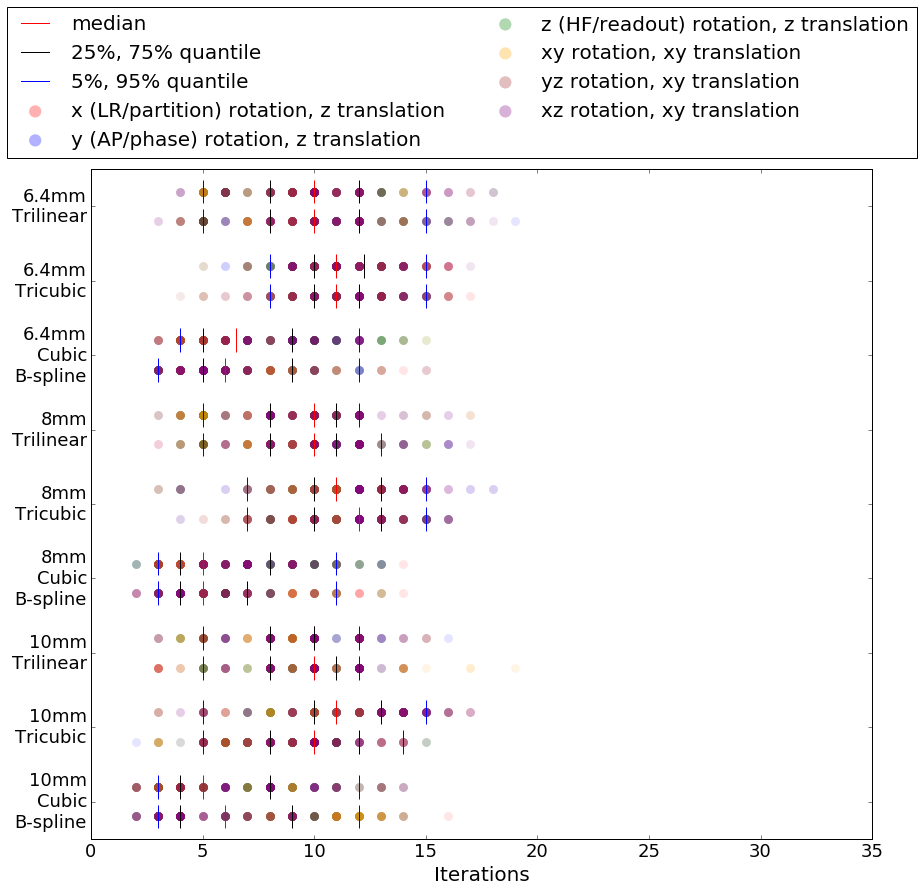

In [45]:
b_spline_quantiles, cubic_quantiles, linear_quantiles = error_plot_all([14,12], -3, -2, -1, 'iterations')

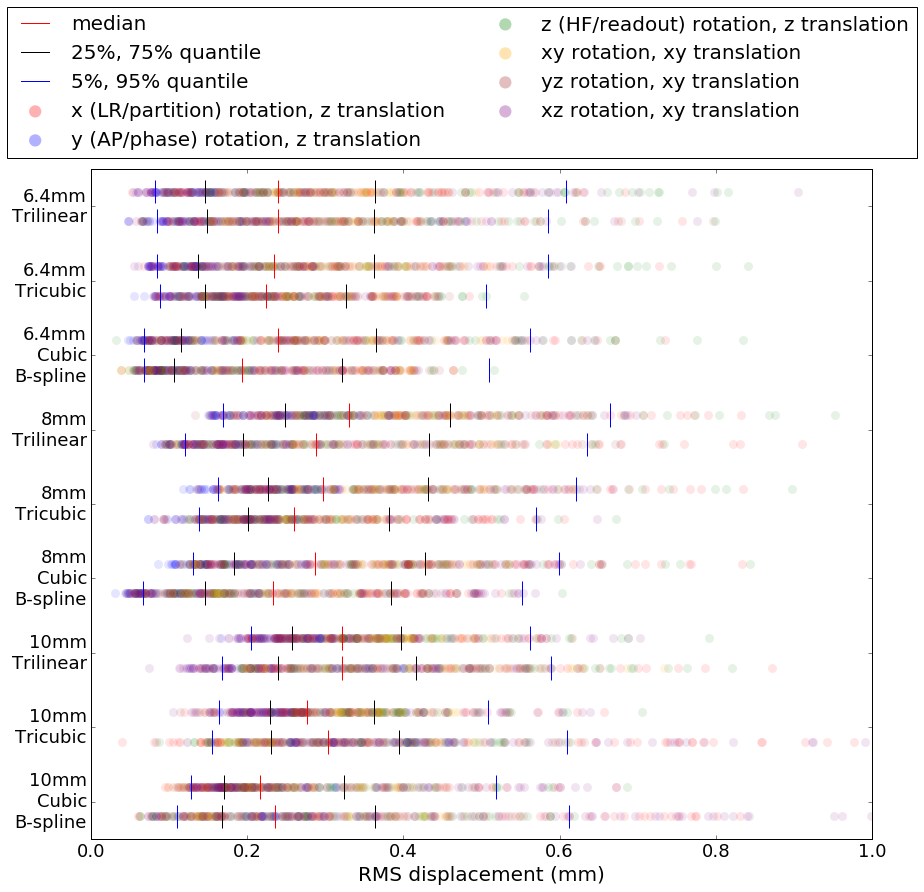

In [46]:
b_spline_quantiles, cubic_quantiles, linear_quantiles = error_plot_all([14,12], 1, 2, 3, plot_type = 'RMS')

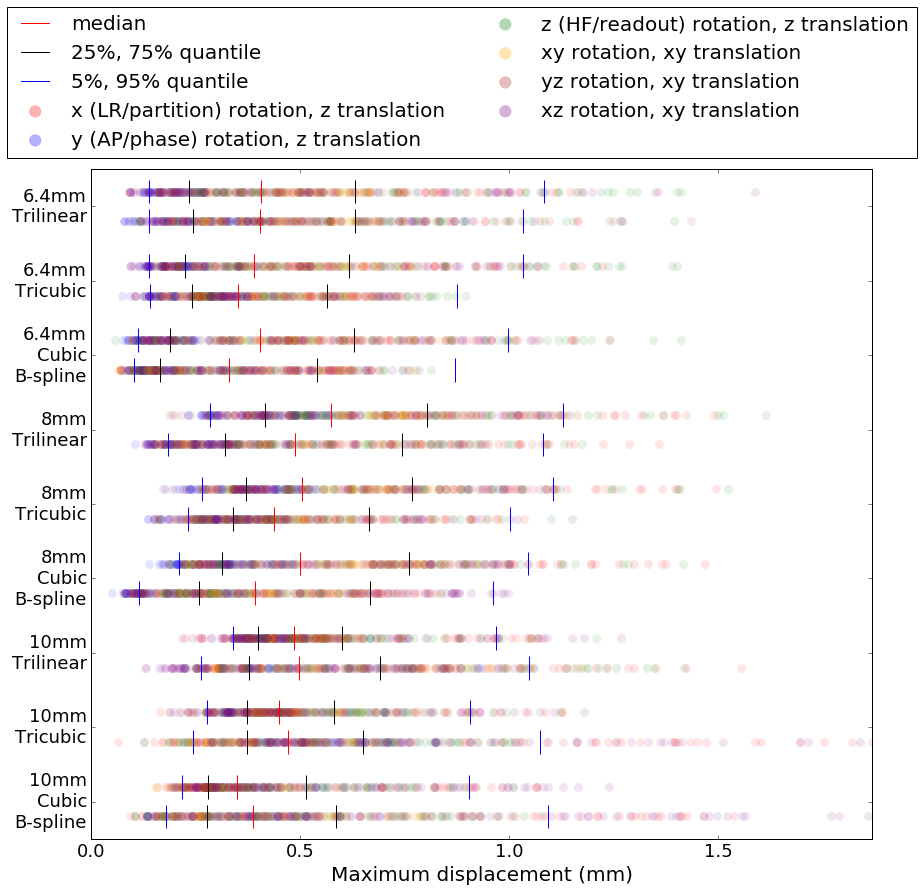

In [47]:
b_spline_quantiles_max, cubic_quantiles_max, linear_quantiles_max = error_plot_all([14,12], 10, 11, 12, plot_type = 'Max')

In [48]:
# Median values
idx_to_res = {3:6.4,2:8,1:10}
for i in xrange(3):
    print 'linear',idx_to_res[i+1], np.round(linear_quantiles[i][2],3)
    print 'cubic',idx_to_res[i+1], np.round(cubic_quantiles[i][2],3)
    print 'b-spline',idx_to_res[i+1], np.round(b_spline_quantiles[i][2],3)
    print

linear 10 0.321
cubic 10 0.303
b-spline 10 0.236

linear 8 0.288
cubic 8 0.277
b-spline 8 0.217

linear 6.4 0.239
cubic 6.4 0.322
b-spline 6.4 0.233



In [49]:
# Quantile prints across resolutions for RMS
quantiles = ['5%', '25%', 'median','75%', '95%']
for i in xrange(5):
    print '\n%s Quantile for 6.4, 8, 10, respectively' % quantiles[i]
    print 'trilinear'
    print '%.2f,%.2f,%.2f'% (linear_quantiles[2][i], linear_quantiles[1][i], linear_quantiles[0][i])
    
    print 'tricubic'
    print '%.2f,%.2f,%.2f'% (cubic_quantiles[2][i], cubic_quantiles[1][i], cubic_quantiles[0][i])
    
    print 'cubic b-spline'
    print '%.2f,%.2f,%.2f'% (b_spline_quantiles[2][i], b_spline_quantiles[1][i], b_spline_quantiles[0][i])


5% Quantile for 6.4, 8, 10, respectively
trilinear
0.08,0.12,0.17
tricubic
0.20,0.16,0.15
cubic b-spline
0.07,0.13,0.11

25% Quantile for 6.4, 8, 10, respectively
trilinear
0.15,0.19,0.24
tricubic
0.26,0.23,0.23
cubic b-spline
0.15,0.17,0.17

median Quantile for 6.4, 8, 10, respectively
trilinear
0.24,0.29,0.32
tricubic
0.32,0.28,0.30
cubic b-spline
0.23,0.22,0.24

75% Quantile for 6.4, 8, 10, respectively
trilinear
0.36,0.43,0.42
tricubic
0.40,0.36,0.39
cubic b-spline
0.38,0.32,0.36

95% Quantile for 6.4, 8, 10, respectively
trilinear
0.59,0.64,0.59
tricubic
0.56,0.51,0.61
cubic b-spline
0.55,0.52,0.61


In [50]:
# Quantile prints across resolutions for max displacement
quantiles = ['5%', '25%', 'median','75%', '95%']
for i in xrange(5):
    print '\n%s Quantile for 6.4, 8, 10, respectively' % quantiles[i]
    print 'trilinear'
    print '%.2f,%.2f,%.2f'% (linear_quantiles_max[2][i], linear_quantiles_max[1][i], linear_quantiles_max[0][i])
    
    print 'tricubic'
    print '%.2f,%.2f,%.2f'% (cubic_quantiles_max[2][i], cubic_quantiles_max[1][i], cubic_quantiles_max[0][i])
    
    print 'cubic b-spline'
    print '%.2f,%.2f,%.2f'% (b_spline_quantiles_max[2][i], b_spline_quantiles_max[1][i], b_spline_quantiles_max[0][i])


5% Quantile for 6.4, 8, 10, respectively
trilinear
0.14,0.19,0.26
tricubic
0.34,0.28,0.24
cubic b-spline
0.12,0.22,0.18

25% Quantile for 6.4, 8, 10, respectively
trilinear
0.24,0.32,0.38
tricubic
0.40,0.37,0.37
cubic b-spline
0.26,0.28,0.28

median Quantile for 6.4, 8, 10, respectively
trilinear
0.40,0.49,0.50
tricubic
0.48,0.45,0.47
cubic b-spline
0.39,0.35,0.39

75% Quantile for 6.4, 8, 10, respectively
trilinear
0.63,0.74,0.69
tricubic
0.60,0.58,0.65
cubic b-spline
0.67,0.51,0.59

95% Quantile for 6.4, 8, 10, respectively
trilinear
1.03,1.08,1.05
tricubic
0.97,0.91,1.07
cubic b-spline
0.96,0.90,1.09


In [51]:
# Quantile Comparison across resolutions
for i in xrange(5):
    print '\npercentage decrease from 10 to 8, 8 to 6.4', i
    print 'trilinear'
    print '%.2f,%.2f'%((linear_quantiles[1][i]-linear_quantiles[0][i])/linear_quantiles[0][i]*100, 
           (linear_quantiles[2][i]-linear_quantiles[1][i])/linear_quantiles[1][i]*100)
    
    print '\ntricubic'
    print '%.2f,%.2f'%((cubic_quantiles[1][i]-cubic_quantiles[0][i])/cubic_quantiles[0][i]*100, 
           (cubic_quantiles[2][i]-cubic_quantiles[1][i])/cubic_quantiles[1][i]*100)
    
    print '\ncubic b-spline'
    print '%.2f,%.2f'%((b_spline_quantiles[1][i]-b_spline_quantiles[0][i])/b_spline_quantiles[0][i]*100, 
           (b_spline_quantiles[2][i]-b_spline_quantiles[1][i])/b_spline_quantiles[1][i]*100)


percentage decrease from 10 to 8, 8 to 6.4 0
trilinear
-28.21,-30.19

tricubic
5.83,25.07

cubic b-spline
16.34,-48.24

percentage decrease from 10 to 8, 8 to 6.4 1
trilinear
-19.00,-23.28

tricubic
-0.27,12.12

cubic b-spline
1.07,-13.93

percentage decrease from 10 to 8, 8 to 6.4 2
trilinear
-10.34,-16.84

tricubic
-8.68,16.20

cubic b-spline
-8.14,7.47

percentage decrease from 10 to 8, 8 to 6.4 3
trilinear
4.19,-16.25

tricubic
-8.09,9.53

cubic b-spline
-11.16,18.71

percentage decrease from 10 to 8, 8 to 6.4 4
trilinear
7.96,-7.83

tricubic
-16.52,10.51

cubic b-spline
-15.28,6.51


In [52]:
# plotting quantiles
def error_plot_rotations_translations_2(figsize, r_idx_6_4, r_idx_8, r_idx_10, t_idx_6_4, t_idx_8, t_idx_10, RMS = True):
    colors = ['red','blue','green','orange','brown','purple']
    quantile_colors = ['blue','black','red','black','blue']
    y = np.arange(1,10)
    labels = ['10mm\nCubic\nB-spline','10mm\nTricubic','10mm\nTrilinear',
              '8mm\nCubic\nB-spline','8mm\nTricubic','8mm\nTrilinear',
              '6.4mm\nCubic\nB-spline','6.4mm\nTricubic','6.4mm\nTrilinear']
    
    plt.figure(figsize = figsize)
    
    plt.subplot(1,2,1)
    plt.yticks(y, labels, rotation='horizontal',fontsize=18)
    plt.xticks(fontsize=18)
    for idx, rot_ax in enumerate(['x','y','z','xy','yz','xz']):
        if rot_ax == 'x':
            label = 'x (LR/partition) rotation, z translation'
        elif rot_ax == 'y':
            label = 'y (AP/phase) rotation, z translation'
        elif rot_ax == 'z':
            label = 'z (HF/readout) rotation, z translation'
        else: 
            label = rot_ax + " rotation, xy translation"
        plt.scatter(-3, -3, lw=0,s = 150, c = colors[idx],alpha = 0.3,marker='o' , label=label)
    plt.plot([-4,-5],[-4,-5],lw=1,c='red',label='median')
    plt.plot([-4,-5],[-4,-5],lw=1,c='black',label='25%, 75% quantile')
    plt.plot([-4,-5],[-4,-5],lw=1,c='blue',label='5%, 95% quantile')
    
    idx = 1-0.2
    error_plot(RMS_bspline[r_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_bspline_oct13_2[r_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[r_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1 
    error_plot(RMS_cubic[r_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[r_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[r_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[r_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[r_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[r_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)
  
    error_plot(RMS_bspline_oct13_2[r_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[r_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[r_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[r_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[r_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[r_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[r_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[r_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)
 
    error_plot(RMS_bspline_oct13_2[r_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[r_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[r_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[r_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[r_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[r_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[r_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[r_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[r_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    plt.ylim([0.5,9.5])
    plt.legend(loc='center left', bbox_to_anchor=(-0.28, 1.13), ncol=2, scatterpoints=1,fontsize = 20)
    #plt.title('Rotation RMS',fontsize = 20)
    if(RMS):
        plt.xlim([0,1])
        plt.xlabel('Rotation Error (degrees)',fontsize=20)
    else:
        plt.xlim([0,1.0])
        plt.xlabel('Maximum displacement\ndue to rotation (mm)',fontsize=20)
    plt.grid('off')

    plt.subplot(1,2,2)
    plt.yticks([])
    plt.xticks(fontsize=18)
    
    idx = 1
    error_plot(RMS_bspline[t_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_bspline_oct13_2[t_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[t_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1 
    error_plot(RMS_cubic[t_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[t_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[t_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[t_idx_10],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_10]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[t_idx_10],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[t_idx_10]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    idx += 1
    error_plot(RMS_bspline[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)
 
    error_plot(RMS_bspline_oct13_2[t_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[t_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[t_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[t_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[t_idx_8],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_8]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[t_idx_8],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[t_idx_8]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_bspline[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_bspline[t_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)
 
    error_plot(RMS_bspline_oct13_2[t_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_bspline_oct13_2[t_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_cubic[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_cubic[t_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_cubic_oct13_2[t_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_cubic_oct13_2[t_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)

    idx += 1
    error_plot(RMS_linear[t_idx_6_4],idx)
    plt.vlines(np.percentile(np.array(RMS_linear[t_idx_6_4]),[5,25,50,75,95]),idx-0.16,idx+0.16,lw=1,color=quantile_colors)

    error_plot(RMS_linear_oct13_2[t_idx_6_4],idx+0.4)
    plt.vlines(np.percentile(np.array(RMS_linear_oct13_2[t_idx_6_4]),[5,25,50,75,95]),idx+0.4-0.16,idx+0.4+0.16,lw=1,color=quantile_colors)
    
    plt.vlines(0,0,7,color = 'r',lw=1,linestyle='--')
    if(RMS):
        plt.xlim([0,1])
        plt.xlabel('Translation Error (mm)',fontsize=20)
    else:
        plt.xlim([0,1.0])
        plt.xlabel('RMS displacemnt\ndue to rotation (mm)',fontsize=20)
    plt.ylim([0.5,9.5])
    plt.grid('off')
    
    plt.show()

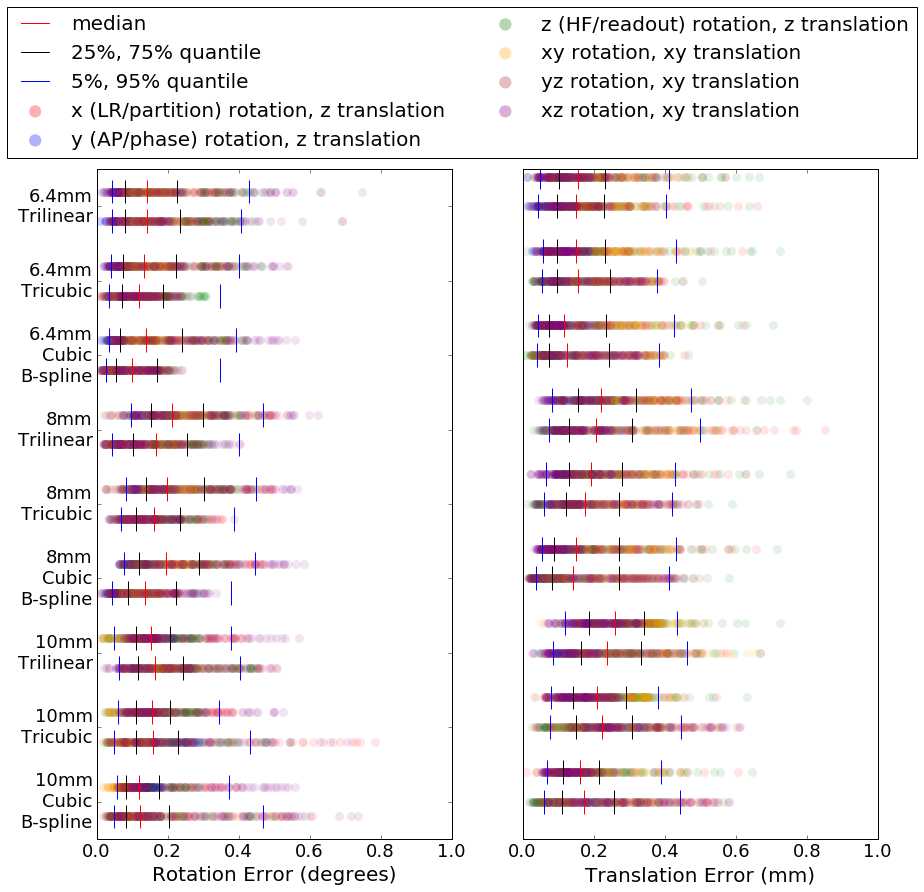

In [56]:
error_plot_rotations_translations_2([14,12], 4, 5, 6, 7, 8, 9, True)

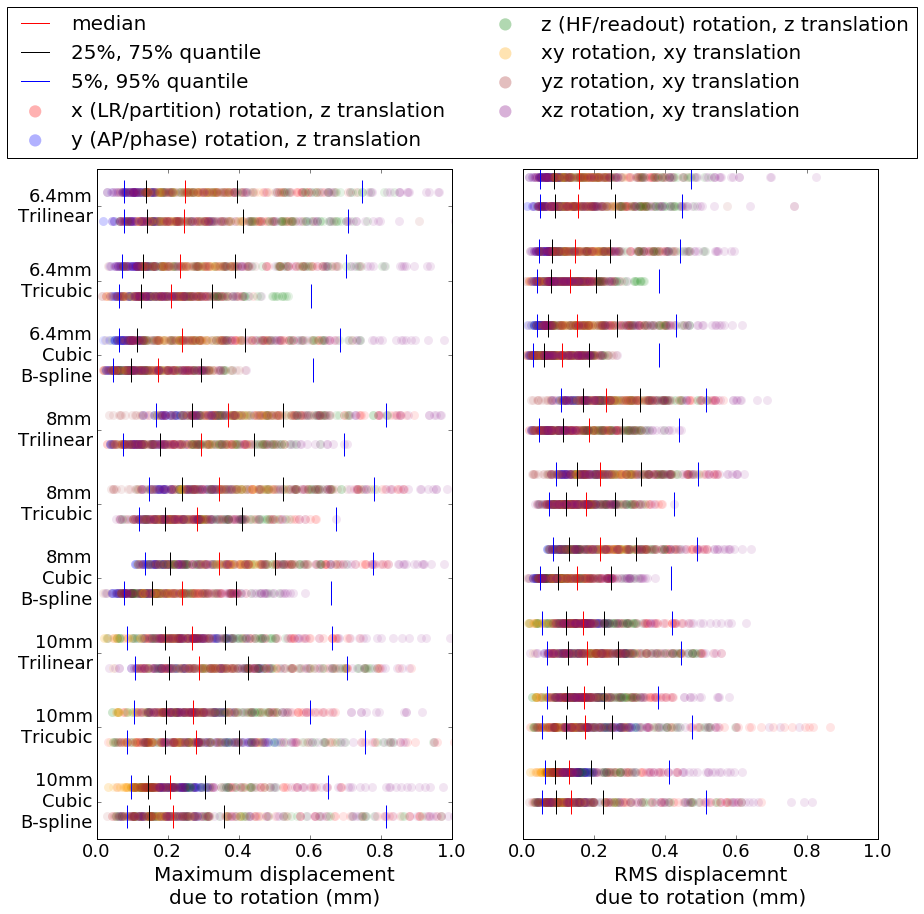

In [54]:
error_plot_rotations_translations_2([14,12], 13, 14, 15, 16, 17, 18, False)

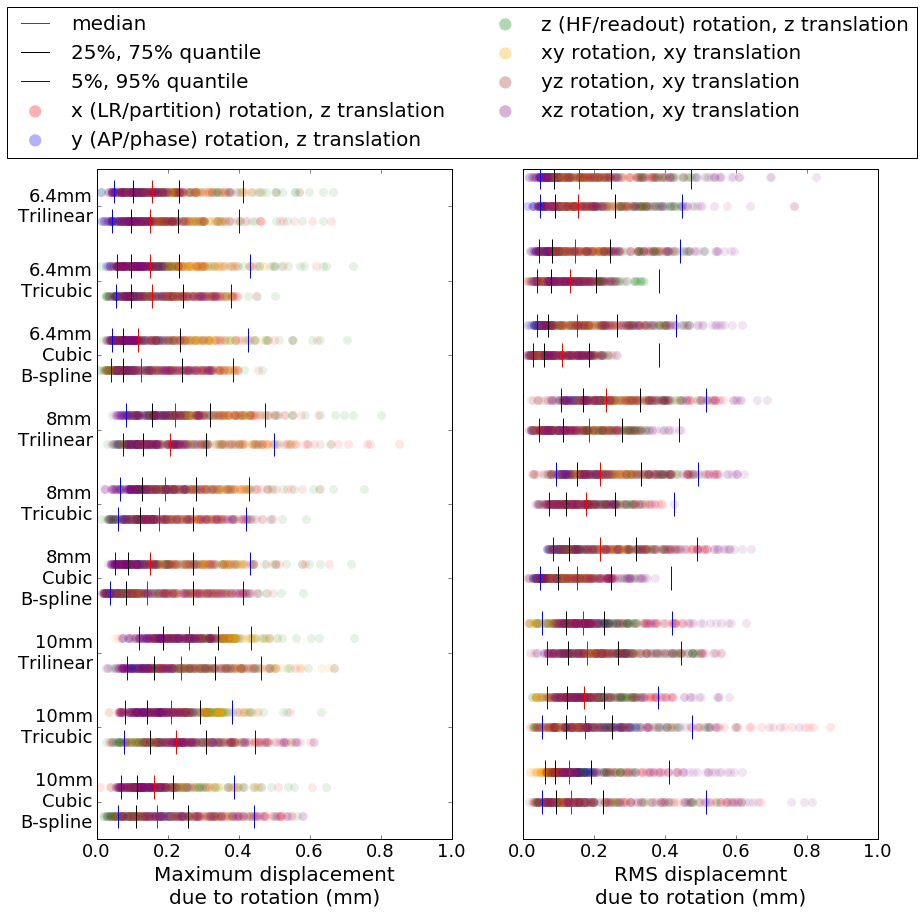

In [55]:
error_plot_rotations_translations_2([14,12], 7, 8, 9, 16,17,18, False)